In [1]:
!pip install roboflow

from roboflow import Roboflow
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="6bpEHFr9vaRCmBUkawKZ", model_format="clip")
dataset = rf.workspace("dermalysis").project("dermalysis-finfv").version(1).download(location="/content/Dermalysis")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import os
os.chdir('/content/Dermalysis')

In [4]:
import os
folder_path = ('/content/Dermalysis/train/Cacar Air')
test = os.listdir(folder_path)
for fichier in test:
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [5]:
import os
folder_path = ('/content/Dermalysis/train/Jamur Kuku')
test = os.listdir(folder_path)
for fichier in test:
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [6]:
import os
folder_path = ('/content/Dermalysis/train/Jerawat')
test = os.listdir(folder_path)
for fichier in test:
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [7]:
import os
folder_path = ('/content/Dermalysis/train/Kurap')
test = os.listdir(folder_path)
for fichier in test:
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [8]:
import os
folder_path = ('/content/Dermalysis/train/Kutu Air')
test = os.listdir(folder_path)
for fichier in test:
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [9]:
from pathlib import Path
image_dir = Path('/content/Dermalysis/train')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [10]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(4)

,Filepath,Label
0,/content/Dermalysis/train/Kurap/aug_0_dermatom...,Kurap
1,/content/Dermalysis/train/Cacar Air/chickenpox...,Cacar Air
2,/content/Dermalysis/train/Kutu Air/15_jpeg.rf....,Kutu Air
3,/content/Dermalysis/train/Cacar Air/chickenpox...,Cacar Air


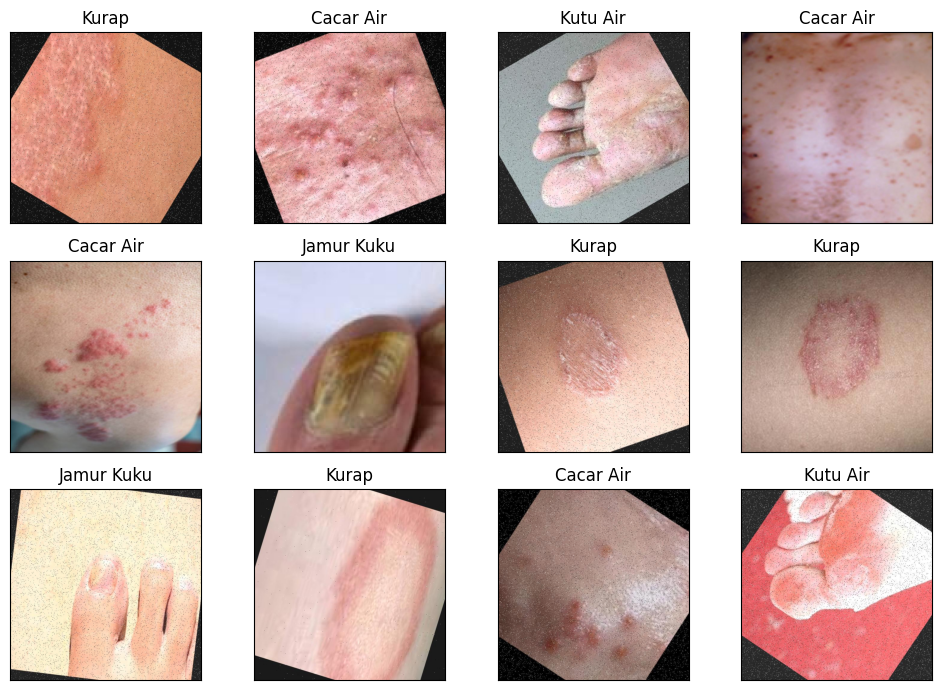

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



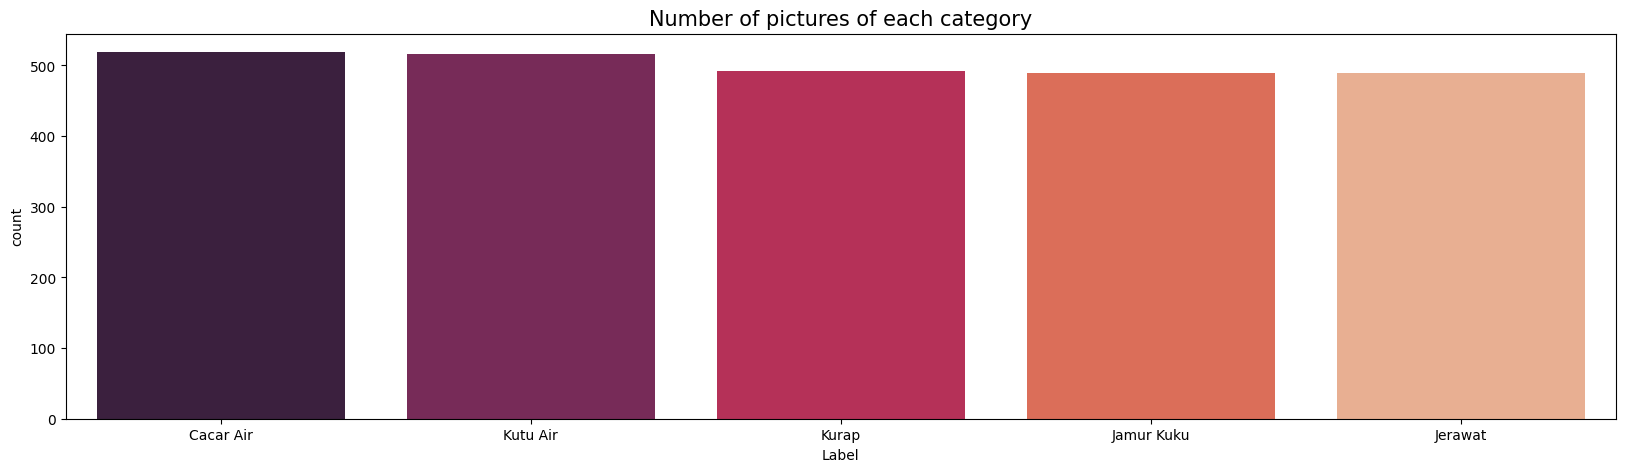

In [12]:
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [13]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [14]:
#data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(416,416),
                                         batch_size=16,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(416,416),
                                         batch_size=16,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2004 validated image filenames belonging to 5 classes.
Found 501 validated image filenames belonging to 5 classes.


In [15]:
from keras import Model, Input
input_shape = (416,416,3)
model_input = Input(shape=input_shape)

In [16]:
from keras.applications.densenet import DenseNet201
from keras import layers
from keras import Model, Input
from tensorflow.keras.optimizers import RMSprop

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
denseNet = DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights="imagenet")

In [18]:
for layer in denseNet.layers:
    layer.trainable = False

In [19]:
denseNet_last_output = denseNet.get_layer('relu').output

# Print informasi tentang output layer terakhir
print('Last layer output shape:', denseNet_last_output.shape)

Last layer output shape: (None, 13, 13, 1920)


In [20]:
# Flatten the output layer to 1 dimension
x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
x_denseNet = layers.Dropout(0.15)(x_denseNet)
# Add a final sigmoid layer for classification
x_denseNet = layers.Dense(5, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(model_input, x_denseNet)
optimizer = RMSprop(learning_rate=0.0001)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
# denseNet_model.load_weights("DenseNetFull.h5")
# denseNet_model.DenseNet201(pretrained=True)
denseNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 422, 422, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 208, 208, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 208, 208, 64)         256       ['conv1/conv[0][0]']      

In [22]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.1 and logs.get('val_loss') < 0.1):
      print("\Stopped, Akurasi mencapai 98%")
      self.model.stop_training = True;

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
# Tentukan path penyimpanan model dengan ekstensi .keras
checkpoint_path = '/content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5'


# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan


In [ ]:
callbacks= myCallback()
history_denseNet = denseNet_model.fit(
                  train_data,
                  validation_data=validasi_data,
                  steps_per_epoch=train_data.n/16,
                  validation_steps=validasi_data.n/16,
                  epochs=20,
                  callbacks=([callbacks],[checkpoint_callback]))

Epoch 1/20
126/125 [==============================] - ETA: 0s - loss: 2.0828 - accuracy: 0.4217
Epoch 1: val_loss improved from inf to 1.07584, saving model to /content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


125/125 [==============================] - 160s 1s/step - loss: 2.0828 - accuracy: 0.4217 - val_loss: 1.0758 - val_accuracy: 0.6008
Epoch 2/20
126/125 [==============================] - ETA: 0s - loss: 1.2188 - accuracy: 0.5923
Epoch 2: val_loss did not improve from 1.07584
125/125 [==============================] - 121s 962ms/step - loss: 1.2188 - accuracy: 0.5923 - val_loss: 1.0952 - val_accuracy: 0.6407
Epoch 3/20
126/125 [==============================] - ETA: 0s - loss: 0.9372 - accuracy: 0.6712
Epoch 3: val_loss improved from 1.07584 to 0.95009, saving model to /content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5
125/125 [==============================] - 125s 1s/step - loss: 0.9372 - accuracy: 0.6712 - val_loss: 0.9501 - val_accuracy: 0.6607
Epoch 4/20
126/125 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.7006
Epoch 4: val_loss improved from 0.95009 to 0.66312, saving model to /content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5
125/125 [=========

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive"
PROJECT_NAME = "Percobaan-Densenet201"
SAVE_MODEL_NAME = "Densenet201.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
denseNet_model.save(save_model_path,include_optimizer=False)

In [ ]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
#display
display_training_curves(
    history_denseNet.history['loss'],
    history_denseNet.history['val_loss'],
    'loss', 211)
display_training_curves(
    history_denseNet.history['accuracy'],
    history_denseNet.history['val_accuracy'],
    'accuracy', 212)

In [ ]:
# Predict the label of the test_images
import numpy as np
pred = denseNet_model.predict(validasi_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

In [ ]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(validasi_df.Label)
print(classification_report(y_test, pred))

In [ ]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(5)],
                  columns = [i for i in range(5)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Define class labels
class_labels = ['Cacar Air', 'Kutu Air', 'Jamur Kuku', 'Jerawat', 'Kurap']

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(416, 416))  # Adjusted size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    return img_array

def predict_image(image_path):
    img_array = load_and_preprocess_image(image_path)
    single_prediction = densenet.predict(img_array)  # Use the correct model
    predicted_class = np.argmax(single_prediction, axis=1)
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label

# File upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
def on_file_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        with open(filename, 'wb') as f:
            f.write(file_info['content'])
        # Display the uploaded image
        img = image.load_img(filename, target_size=(416, 416))  # Adjusted size
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # Make a prediction
        predicted_label = predict_image(filename)
        print(f"Predicted Label for {filename}: {predicted_label}")

upload_widget.observe(on_file_upload_change, names='value')
display(upload_widget)